In [1]:
import pyrootutils
import omegaconf
from omegaconf import OmegaConf
import os
import hydra
from hydra import compose, initialize
from pathlib import Path
import torch

/home/cyanos/anaconda3/envs/augtransfer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = pyrootutils.setup_root('.', pythonpath=True)
os.chdir(root)

In [153]:
run_dir = root / 'outputs/cifar10_resnet32/local/none/2022-11-17_07-19-21'
hydra_cfg_path = run_dir / '.hydra'

In [154]:
with initialize(version_base=None, config_path= '..' / hydra_cfg_path.relative_to(root)):
    cfg = compose(config_name="config", return_hydra_config=True, overrides=["paths.output_dir=notebooks/tmp"])

In [155]:
model = hydra.utils.instantiate(cfg.dmt.model)
model = model.load_from_checkpoint(run_dir / 'lightning_logs/version_0/checkpoints/epoch=199-step=78200.ckpt', net=model.net)

In [156]:
trainer = hydra.utils.instantiate(cfg.dmt.trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [157]:
datamodule = hydra.utils.instantiate(cfg.dmt.datamodule, test_augmentation='none', test_on_train=.0)

In [158]:
metrics = trainer.test(model=model, datamodule=datamodule)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 44.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.881600022315979     │
│         test/loss         │    0.44373130798339844    │
└───────────────────────────┴───────────────────────────┘

In [143]:
from torch.utils.data import Subset

In [144]:
datamodule = hydra.utils.instantiate(cfg.dmt.datamodule, augmentation='rgb_shift')
datamodule.setup('test')
train_loader = datamodule.train_dataloader()

model.cuda()
model.eval()
all_features = []
all_labels = []
train_iter = iter(train_loader)
with torch.no_grad():
    for i in range(100):
        batch = next(train_iter)
        images, labels = batch
        all_labels.append(labels)
        images, labels = images.cuda(), labels.cuda()
        all_features.append(model.net.feature(images).detach().cpu())
all_features = torch.concat(all_features)
all_labels = torch.concat(all_labels)


In [166]:
datamodule = hydra.utils.instantiate(cfg.dmt.datamodule, augmentation='rgb_shift', test_augmentation='perspective')
datamodule.setup('test')
print(datamodule.data_test.transform)

data_loader = datamodule.test_dataloader()

model.cuda()
model.eval()
all_features = []
all_labels = []
with torch.no_grad():
    for i in range(1000):
        data_iter = iter(data_loader)
        batch = next(data_iter)
        images, labels = batch
        all_labels.append(labels)
        images, labels = images.cuda(), labels.cuda()
        all_features.append(model.net.feature(images).detach().cpu())
all_features = torch.concat(all_features)
all_labels = torch.concat(all_labels)


Compose([
  Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201), max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [167]:
all_features.shape

torch.Size([1000, 64])

In [174]:
all_preds = model.net.linear(all_features.cuda())
all_preds = torch.argmax(all_preds, dim=1)

## Feature analysis using t-SNE

In [120]:
import numpy as np
from sklearn import decomposition
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [177]:
X_training = all_features.detach().cpu().numpy()
# y_training = all_labels.cpu().numpy()
y_training = all_preds.cpu().numpy()


In [50]:
X_training = np.concatenate([X_training, all_features.detach().cpu().numpy()], axis=0)
y_training = np.concatenate([y_training, all_labels.data.fill_(-3).cpu().numpy()], axis=0)

In [178]:
pca = decomposition.PCA(n_components=30)
X_training_reduced = pca.fit_transform(X_training)

Since t-SNE is quite complex, it is worth to compress the data. Let say that 99% is enough.

In [179]:
np.sum( pca.explained_variance_ratio_ )

0.99762744

In [180]:
tsne = TSNE(n_components=2, init='random', learning_rate='auto')
X_training_reduced_tsne = tsne.fit_transform(X_training_reduced)

In [181]:
df = pd.DataFrame(X_training_reduced_tsne[:, :2], columns=['comp_1', 'comp_2'])
df['y'] = y_training

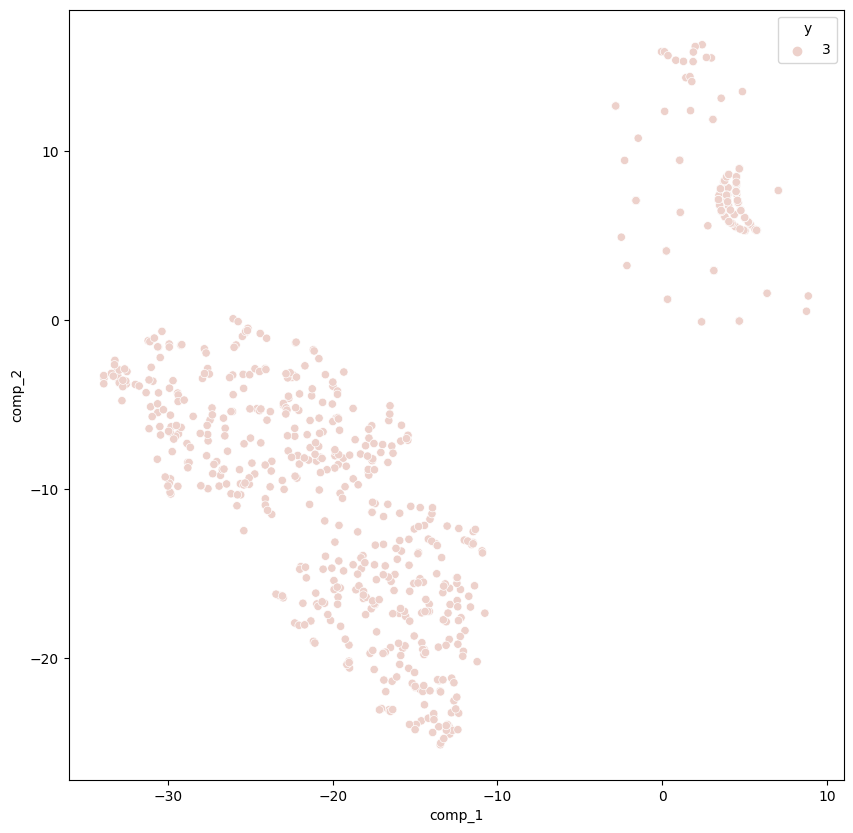

In [182]:
plt.figure( figsize=(10,10) )
# plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
sns.scatterplot(df, x='comp_1', y='comp_2', hue='y')
plt.show()

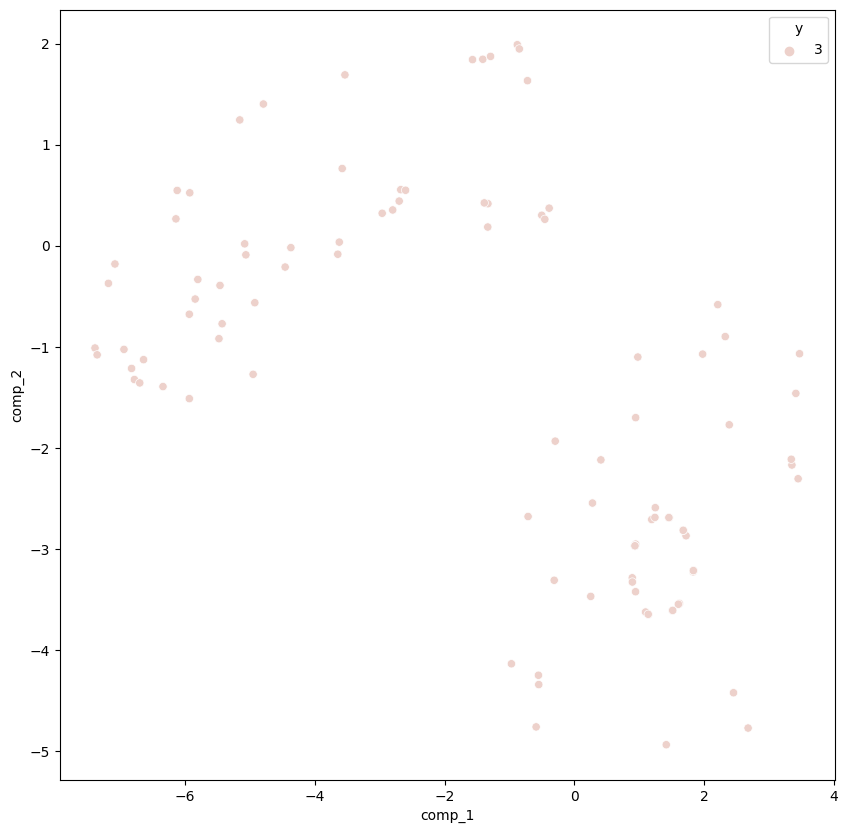

In [152]:
plt.figure( figsize=(10,10) )
# plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
sns.scatterplot(df, x='comp_1', y='comp_2', hue='y')
plt.show()

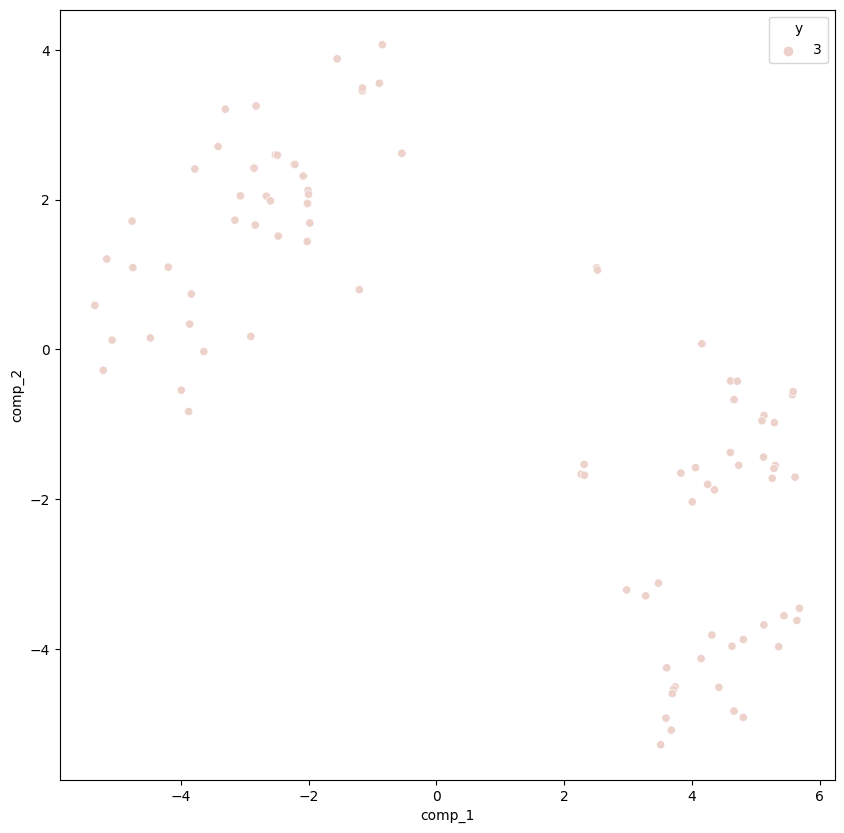

In [136]:
plt.figure( figsize=(10,10) )
# plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
sns.scatterplot(df, x='comp_1', y='comp_2', hue='y')
plt.show()

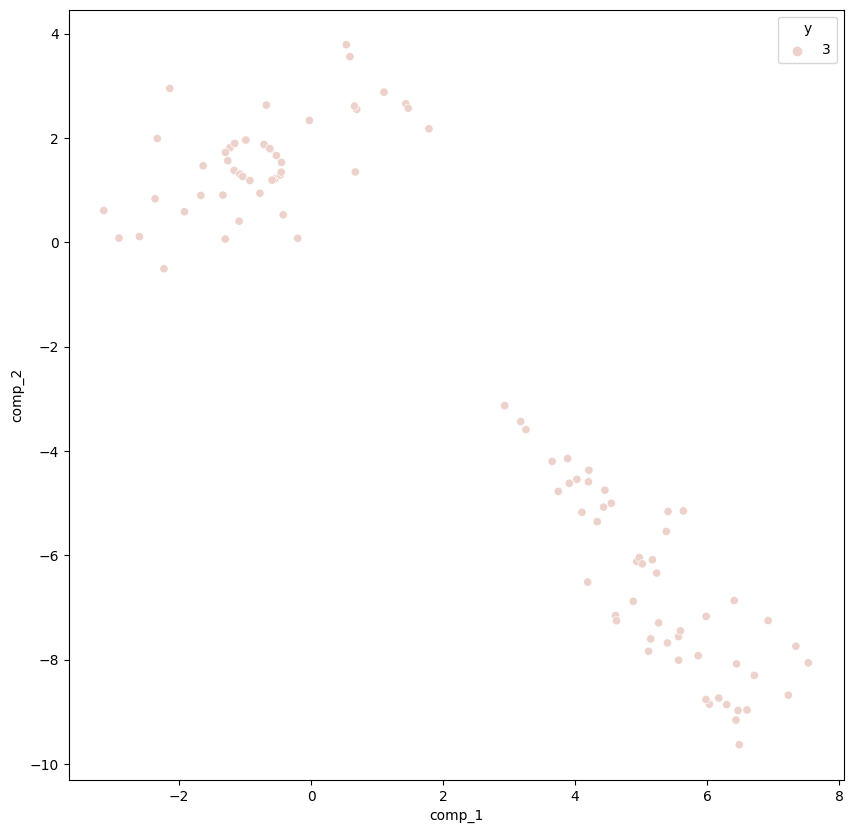

In [110]:
plt.figure( figsize=(10,10) )
# plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
sns.scatterplot(df, x='comp_1', y='comp_2', hue='y')
plt.show()

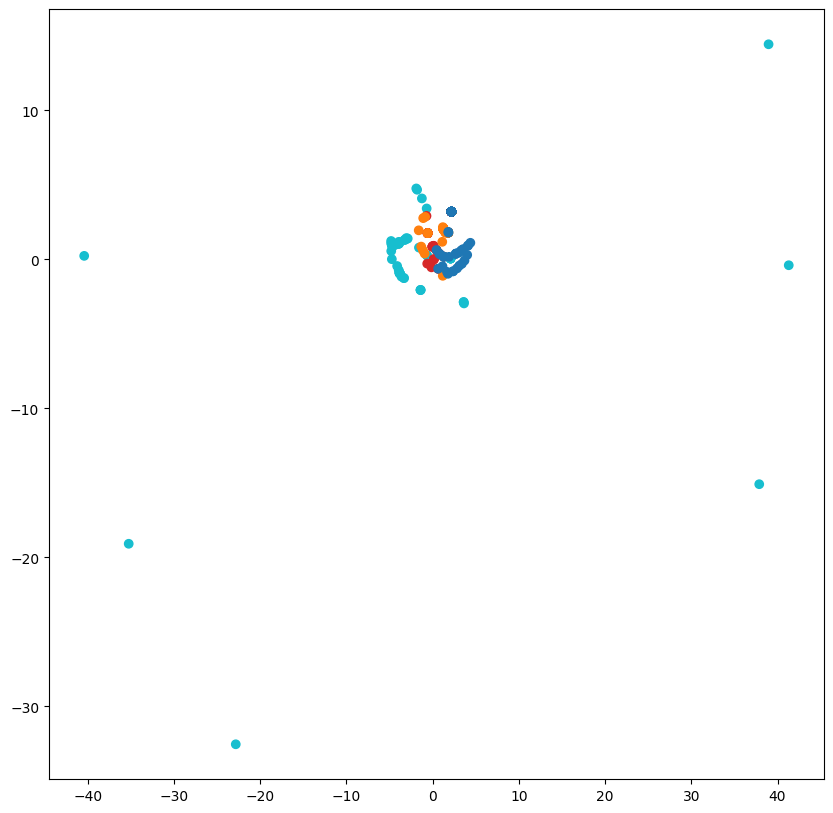

In [62]:
plt.figure( figsize=(10,10) )
plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
plt.show()